In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
%matplotlib inline

In [2]:
# Trade data
df = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
apple = df[df['RIC'] == 'AAPL.O']
apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date

<ipython-input-2-eb84b3a7ca8e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date


In [3]:
# Auction price data
auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
apple_auction = auction[auction['RIC'] == 'AAPL.O']
apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date

<ipython-input-3-31c36d887279>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date


In [318]:
# Data Processing (10 minute intervals)

dates = apple['Date'].unique()
daily_volatility = []
avg_20day_volatility = []
stocks = []
dates_final = []
auction_log_returns = []
volumes = []

# i = 0
for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min_volume = pd.DataFrame(apple_today['Volume'].resample("10T").sum())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    apple_today_10min = apple_today_10min.join(apple_today_10min_volume)
    apple_today_10min['log_returns'] = abs(np.log(apple_today_10min['Close']/apple_today_10min['Open'])) # alternate volatility formula
#     apple_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1) * np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
    volatility_today = apple_today_10min['log_returns'].values
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
    auction_log_returns_today = abs(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1]))
    auction_log_returns.append(auction_log_returns_today)
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
    
    # Average daily volatility (later used for 20 day moving average)
    daily_volatility.append(np.sqrt(39)*np.sqrt(np.mean(np.square(apple_today_10min['log_returns'].values))))
    
    # Total volume for each complete trade day between 930 and 1550
    volumes.append(sum(apple_today_10min[:-1]['Volume']))

volatility_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility})
volatility_df['volatility_ewma20'] = volatility_df['daily_volatility'].ewm(span=20).mean()

stocks = stocks[20:]
stocks = np.vstack(stocks).T # Training data for Anderson model
avg_20day_volatility_raw = np.array(volatility_df['volatility_ewma20'])
avg_20day_volatility = np.array(volatility_df['volatility_ewma20'][20:]) # Sigma_t input for Anderson model

In [319]:
# Simple linear regression without Anderson coefficient
final_df = pd.DataFrame({
    'Date': dates_final, 
    'Volume': volumes,
    'Avg20_Volatility': avg_20day_volatility_raw, 
    'Auction_Log_Returns': auction_log_returns
})
final_df = final_df[np.isnan(final_df['Avg20_Volatility']) == False]
final_df

,Date,Volume,Avg20_Volatility,Auction_Log_Returns
0,2020-09-01,110260062,0.020773,0.002911
1,2020-09-02,153259555,0.043159,0.002508
2,2020-09-03,183308338,0.042739,0.000414
3,2020-09-04,256617992,0.050219,0.001073
4,2020-09-08,168228403,0.047753,0.005128
...,...,...,...,...
246,2021-08-26,36685181,0.009485,0.001896
247,2021-08-27,38310675,0.009395,0.000303
248,2021-08-30,71476524,0.009672,0.001251
249,2021-08-31,50950469,0.009691,0.004010


In [320]:
from sklearn.linear_model import LinearRegression
model_no_volatility = LinearRegression()
model_no_volatility.fit(final_df[['Volume','Avg20_Volatility']][:200], final_df[['Auction_Log_Returns']][:200])

LinearRegression()

In [321]:
y_pred = model_no_volatility.predict(final_df[['Volume','Avg20_Volatility']][200:])

In [322]:
# Without volatility
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model_no_volatility.coef_)
print("Mean Absolute Error:", mean_absolute_error(final_df[['Auction_Log_Returns']][200:], y_pred))
print("Mean Squared Error:", mean_squared_error(final_df[['Auction_Log_Returns']][200:], y_pred))
print("Coefficient of Determination:", r2_score(final_df[['Auction_Log_Returns']][200:], y_pred))

Model Coefficients: [[1.60063740e-11 2.48852939e-03]]
Mean Absolute Error: 0.001122918323385971
Mean Squared Error: 1.7085564101929769e-06
Coefficient of Determination: -0.37825060088482165


In [323]:
class FlexibleFourierRegression():
    '''
    See P.152 Anderson(1997) Appendix B for details
    '''
    
    def __init__(self, N, J=0, P=0, di=[]):
        self.J = J
        self.D = len(di)
        self.P = P
        
        self.N = N
        self.di = di
        self.Id = zeros(shape=(N,))
        self.mu0 = ones(shape=(J+1,))
        self.mu1 = ones(shape=(J+1,))
        self.mu2 = ones(shape=(J+1,))
        self.lamb = ones(shape=(self.D,))
        self.gamma = ones(shape=(P, J+1))
        self.delta = ones(shape=(P, J+1))
        self.p = arange(1, P + 1, 1)
        self.x = concatenate([self.mu0.ravel(), self.mu1.ravel(), self.mu2.ravel(),
            self.lamb.ravel(), self.gamma.ravel(), self.delta.ravel()])    
        
    def train(self, y, sigma_t, tol=0.1):
        """
        Trains model using flexible fourier functional form.
        
        Parameters
        ----------
        y : dependent variable
        
        sigma_t: estimated conditional volatility for day t,
        sigma_t is scalar or vector depending on vector=False/True.
        
        
        
        Returns
        -------
        Regression stats
        """
        assert y.shape[0] == self.N, "input y should have shape[0] == N:"
        n = arange(0, self.N, 1)
        J = self.J
        ## Learning weights for the following parameters
        ## self.mu0, self.mu1, self.mu2, self.lamb, self.gamma, self.delta

        def lsq_fun(x):
            
            mu0 = x[0: J+1]
            mu1 = x[J+1: 2*J+2]
            mu2 = x[2*J+2: 3*J+3]
            lamb = x[3*J+3:3*J+3+self.D]
            gamma = x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
            delta = x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
            
            gamma = repeat(expand_dims(gamma, axis=0), self.N, axis=0)
            delta = repeat(expand_dims(delta, axis=0), self.N, axis=0)            
            N1 = (self.N + 1) / 2
            N2 = (self.N + 1) * (self.N + 2) / 6            
            
            dummy = self.Id.copy()
            dummy[self.di] = lamb
            dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
            
            mu0 = repeat(expand_dims(mu0, axis=0), self.N, axis=0)
            quad = mu0 + outer(n / N1, mu1) + outer(square(n) / N2, mu2)
            cosine = cos(2 * outer(n, self.p) * pi / self.N)
            sine = sin(2 * outer(n, self.p) * pi / self.N)
            cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
            sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)  
            fourier_expand = gamma * cosine + delta * sine
            fourier = fourier_expand.sum(axis=1)

            sigma = full(fill_value=sigma_t, shape=(self.N, J+1))
            for j in range(J+1):
                sigma[:,j] = power(sigma[:,j], j)   

            result = (sigma * (quad + dummy + fourier)).sum(axis=-1)
            cost = square(result - y).mean()
            
            return cost

        def lsq_fun_vec(x):
            
            mu0 = x[0: J+1]
            mu1 = x[J+1: 2*J+2]
            mu2 = x[2*J+2: 3*J+3]
            lamb = x[3*J+3:3*J+3+self.D]
            gamma = x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
            delta = x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
            
            gamma = repeat(expand_dims(gamma, axis=0), self.N, axis=0)
            delta = repeat(expand_dims(delta, axis=0), self.N, axis=0)            
            N1 = (self.N + 1) / 2
            N2 = (self.N + 1) * (self.N + 2) / 6            
            
            dummy = self.Id.copy()
            dummy[self.di] = lamb
            dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
            
            mu0 = repeat(expand_dims(mu0, axis=0), self.N, axis=0)
            quad = mu0 + outer(n / N1, mu1) + outer(square(n) / N2, mu2)
            cosine = cos(2 * outer(n, self.p) * pi / self.N)
            sine = sin(2 * outer(n, self.p) * pi / self.N)
            cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
            sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)  
            fourier_expand = gamma * cosine + delta * sine
            fourier = fourier_expand.sum(axis=1)
            
            component = fourier + quad + dummy
            component = repeat(expand_dims(component, axis=1), len(sigma_t), axis=1)  
            
            sigma = repeat(expand_dims(sigma_t, axis=0), self.N, axis=0)
            sigma_J = repeat(expand_dims(sigma, axis=-1), J+1, axis=-1)
            for j in range(J+1):
                sigma_J[:,:,j] = power(sigma_J[:,:,j], j)   
            
            result = (sigma_J * component).sum(axis=-1)
            cost = square(result - y).mean()
            
            return cost
        

        sigma_t = ravel(sigma_t)
        assert sigma_t.shape[0] == y.shape[1], "sigma_t should have shape (t, ) and y should have shape (N, t)"
        res = minimize(lsq_fun_vec, self.x, tol=tol)

        self.mu0 = res.x[0: J+1]
        self.mu1 = res.x[J+1: 2*J+2]
        self.mu2 = res.x[2*J+2: 3*J+3]
        self.lamb = res.x[3*J+3:3*J+3+self.D]
        self.gamma = res.x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
        self.delta = res.x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))            
        
        return res
        
    def predict(self, sigma_t, vector=False):
        
        N = self.N
        D = self.D
        J = self.J
        P = self.P
        p = self.p
        
        gamma = repeat(expand_dims(self.gamma, axis=0), N, axis=0)
        delta = repeat(expand_dims(self.delta, axis=0), N, axis=0)
        n = arange(0, N, 1)
        N1 = (N + 1) / 2
        N2 = (N + 1) * (N + 2) / 6
        
        dummy = self.Id.copy()
        dummy[self.di] = self.lamb
        dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
        
        quad = self.mu0 + outer(n / N1, self.mu1) + outer(square(n) / N2, self.mu2)
        
        cosine = cos(2 * outer(n, self.p) * pi / N)
        sine = sin(2 * outer(n, self.p) * pi / N)
        cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
        sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)
        fourier_expand = gamma * cosine + delta * sine
        fourier = fourier_expand.sum(axis=1)

        sigma_t = ravel(sigma_t)
        component = fourier + quad + dummy
        component = repeat(expand_dims(component, axis=1), sigma_t.shape[0], axis=1)  
        sigma = repeat(expand_dims(sigma_t, axis=0), self.N, axis=0)
        sigma_J = repeat(expand_dims(sigma, axis=-1), J+1, axis=-1)
        for j in range(J+1):
            sigma_J[:,:,j] = power(sigma_J[:,:,j], j)               
        result = (sigma_J * component).sum(axis=-1)
            
        return result

In [324]:
stocks2 = stocks.T
stocks2 = stocks2[:200].T
avg_20day_volatility2 = avg_20day_volatility[:200]

In [325]:
fourier = FlexibleFourierRegression(N=39, di=[], J=6, P=20) # 39 10-minute intervals in each trade day
res = fourier.train(stocks, avg_20day_volatility, 0.000001)
print("optimizer success: {}".format(res.success))
print("objective function (mse): {:.5f}".format(res.fun))

optimizer success: True
objective function (mse): 0.00000


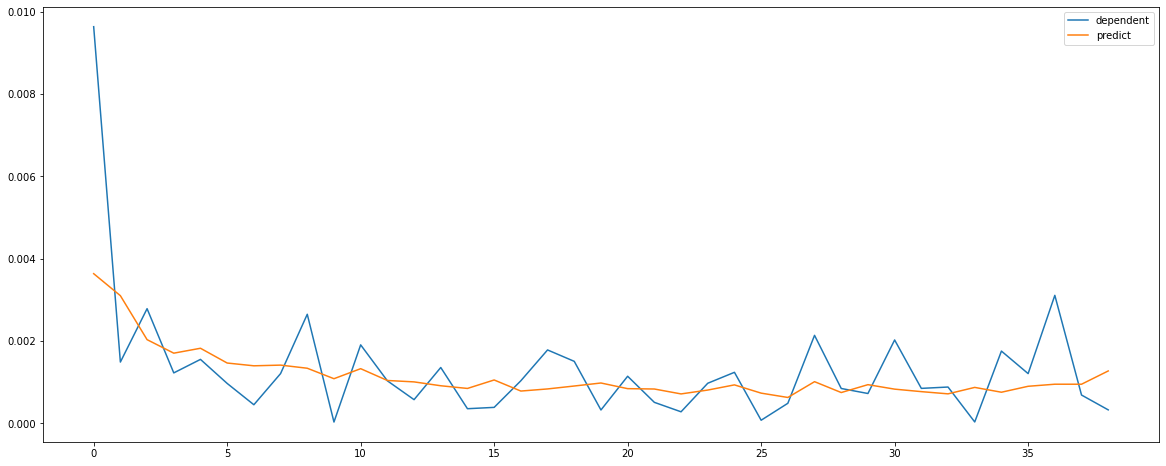

In [326]:
n=230
result = fourier.predict(avg_20day_volatility[n])

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(stocks.T[n], label="dependent")
ax.plot(result, label="predict")
ax.legend()

In [329]:
results = [None for i in range(20)]
for vol in avg_20day_volatility:
    result = fourier.predict(vol)
    results.append(result[-1][0])
results = np.array(results)

In [330]:
# Simple linear regression with Anderson coefficient
final_df = pd.DataFrame({
    'Date': dates_final, 
    'Volume': volumes,
    'Avg20_Volatility': avg_20day_volatility_raw, 
    'Anderson': results,
    'Auction_Log_Returns': auction_log_returns
})
final_df = final_df[final_df['Anderson'] > -float('inf')]
final_df

,Date,Volume,Avg20_Volatility,Anderson,Auction_Log_Returns
20,2020-09-30,105065483,0.025016,0.00421421,0.003964
21,2020-10-01,86984758,0.023754,0.00406849,0.003689
22,2020-10-02,110015217,0.023633,0.00405347,0.004855
23,2020-10-05,78867587,0.022342,0.00388314,0.001374
24,2020-10-06,126395927,0.022328,0.00388116,0.000442
...,...,...,...,...,...
246,2021-08-26,36685181,0.009485,0.00113373,0.001896
247,2021-08-27,38310675,0.009395,0.00110763,0.000303
248,2021-08-30,71476524,0.009672,0.00118704,0.001251
249,2021-08-31,50950469,0.009691,0.00119264,0.004010


In [331]:
from sklearn.linear_model import LinearRegression
model_volatility = LinearRegression()
model_volatility.fit(final_df[['Volume','Avg20_Volatility','Anderson']][:200], final_df[['Auction_Log_Returns']][:200])

LinearRegression()

In [332]:
y_pred = model_volatility.predict(final_df[['Volume','Avg20_Volatility','Anderson']][200:])

In [333]:
# Without volatility
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model_no_volatility.coef_)
print("Mean Absolute Error:", mean_absolute_error(final_df[['Auction_Log_Returns']][200:], y_pred))
print("Mean Squared Error:", mean_squared_error(final_df[['Auction_Log_Returns']][200:], y_pred))
print("Coefficient of Determination:", r2_score(final_df[['Auction_Log_Returns']][200:], y_pred))

Model Coefficients: [[1.60063740e-11 2.48852939e-03]]
Mean Absolute Error: 0.0007904079817085511
Mean Squared Error: 9.297858796746249e-07
Coefficient of Determination: 0.07172244944892547


In [328]:
### Log return as intraday volatility

# Model Coefficients: [[-1.32305695e-11  1.22013923e-02]]
# Mean Absolute Error: 0.001506950281610983
# Mean Squared Error: 3.6732968582777996e-06
# Coefficient of Determination: -0.20615114365164033

In [327]:
### Abs log return as intraday volatility

# Model Coefficients: [[1.60063740e-11 2.48852939e-03]]
# Mean Absolute Error: 0.001122918323385971
# Mean Squared Error: 1.7085564101929769e-06
# Coefficient of Determination: -0.37825060088482165